# **Project: House Price Prediction**

**Objective:** The objective of this project is to develop a robust machine learning model capable of accurately predicting house prices based on various features such as location, property size, number of bedrooms and bathrooms, furnishing status, and additional property attributes.

## **Dataset Overview**
This dataset provides a detailed snapshot of real estate properties listed in Dubai, UAE, as of August 2024. The dataset includes over 5,000 listings scraped using the Apify API from Propertyfinder and various other real estate websites in the UAE. The data includes key details such as the number of bedrooms and bathrooms, price, location, size, and whether the listing is verified. All personal identifiers, such as agent names and contact details, have been ethically removed.

### Importing all neccesary librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df= pd.read_csv('uae_real_estate_2024.csv')

### Data Preprocessing

In [3]:
df.shape

(5058, 12)

In [4]:
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,price,verified,priceDuration,sizeMin,furnishing,description
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3,2,2024-08-14T12:02:53Z,Residential for Sale,2500000,True,sell,1323 sqft,NO,MNA Properties is delighted to offer this apar...
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3,2,2024-08-13T05:45:16Z,Residential for Sale,7200000,True,sell,1410 sqft,YES,"Apartment for sale in La Vie, Jumeirah Beach R..."
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3,4,2024-08-14T06:24:28Z,Residential for Sale,3600000,True,sell,2324 sqft,NO,Treo Homes is very pleased to be bringing to t...
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3,2,2024-08-15T06:07:22Z,Residential for Sale,2999999,True,sell,1647 sqft,NO,2 Bedrooms + Study | Near Pool &amp; Park | Pr...
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3,3,2024-08-09T08:28:59Z,Residential for Sale,2449999,True,sell,2105 sqft,NO,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           5058 non-null   object
 1   displayAddress  5058 non-null   object
 2   bathrooms       4938 non-null   object
 3   bedrooms        4935 non-null   object
 4   addedOn         5058 non-null   object
 5   type            5058 non-null   object
 6   price           5058 non-null   int64 
 7   verified        5058 non-null   bool  
 8   priceDuration   5058 non-null   object
 9   sizeMin         5058 non-null   object
 10  furnishing      5056 non-null   object
 11  description     5057 non-null   object
dtypes: bool(1), int64(1), object(10)
memory usage: 439.7+ KB


In [6]:
df.isnull().sum()

title               0
displayAddress      0
bathrooms         120
bedrooms          123
addedOn             0
type                0
price               0
verified            0
priceDuration       0
sizeMin             0
furnishing          2
description         1
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,price
count,4.930000e+03
mean,4.937866e+06
std,9.720128e+06
min,1.000000e+05
25%,1.200000e+06
50%,2.350000e+06
75%,4.400000e+06
max,1.990000e+08


In [10]:
df['bathrooms'].value_counts()

bathrooms
2       1208
1       1037
3        902
4        685
5        510
6        273
7        206
7+       108
none       1
Name: count, dtype: int64

In [11]:
df['bedrooms'].value_counts()

bedrooms
1         1263
2         1087
3          798
4          713
studio     541
5          366
6          122
7           25
7+          15
Name: count, dtype: int64

In [12]:
df['bathrooms'] = df['bathrooms'].replace({
    'none': 0,
    '7+': 8
})

In [13]:
df['bedrooms'] = df['bedrooms'].replace({
    'studio': 0,
    '7+': 8
})

In [14]:
df['bathrooms']= df['bathrooms'].astype(np.int64)
df['bedrooms']= df['bedrooms'].astype(np.int64)

In [15]:
df.dtypes

title             object
displayAddress    object
bathrooms          int64
bedrooms           int64
addedOn           object
type              object
price              int64
verified            bool
priceDuration     object
sizeMin           object
furnishing        object
description       object
dtype: object

In [16]:
df.nunique()

title             4876
displayAddress    1840
bathrooms            9
bedrooms             9
addedOn           4799
type                 1
price             1503
verified             2
priceDuration        1
sizeMin           2448
furnishing           3
description       4816
dtype: int64

In [17]:
df = df.drop(['type', 'priceDuration'], axis=1) #they have only a single unique value, which means they'll be just noise 

In [18]:
df.furnishing.unique()

array(['NO', 'YES', 'PARTLY'], dtype=object)

In [19]:
le = LabelEncoder()
df['furnishing'] = le.fit_transform(df['furnishing'])
# 0 = no, 1 = partly, 2 = yes

In [20]:
df['sizeMin']= df['sizeMin'].str.replace('sqft', '')

In [21]:
df['sizeMin']

0       1323 
1       1410 
2       2324 
3       1647 
4       2105 
        ...  
5053    1268 
5054     854 
5055    3813 
5056    1300 
5057    3685 
Name: sizeMin, Length: 4930, dtype: object

In [22]:
df['sizeMin']= df['sizeMin'].astype(np.int64)

In [23]:
df.dtypes

title             object
displayAddress    object
bathrooms          int64
bedrooms           int64
addedOn           object
price              int64
verified            bool
sizeMin            int64
furnishing         int32
description       object
dtype: object

## Feature Engineering

In [24]:
df['addedOn'] = pd.to_datetime(df['addedOn'])

In [25]:
df['addedOn'] = (df['addedOn'] - df['addedOn'].min()).dt.days 

In [26]:
df['price_per_sqft'] = df['price'] / df['sizeMin']


In [27]:
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,price,verified,sizeMin,furnishing,description,price_per_sqft
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3,2,1169,2500000,True,1323,0,MNA Properties is delighted to offer this apar...,1889.644747
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3,2,1167,7200000,True,1410,2,"Apartment for sale in La Vie, Jumeirah Beach R...",5106.382979
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3,4,1168,3600000,True,2324,0,Treo Homes is very pleased to be bringing to t...,1549.053356
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3,2,1169,2999999,True,1647,0,2 Bedrooms + Study | Near Pool &amp; Park | Pr...,1821.493018
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3,3,1163,2449999,True,2105,0,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...,1163.895012


### Exploratory Data Analysis

Text(0.5, 1.0, 'Verified Listings')

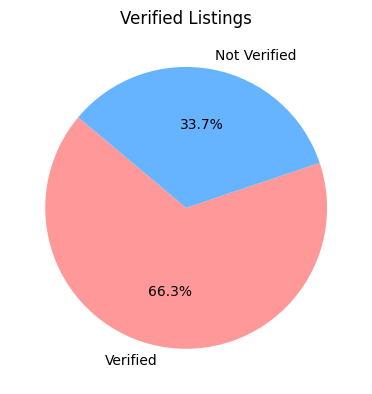

In [29]:
plt.figure(figsize=(10, 5))
verified_counts = df['verified'].value_counts()
verified_labels = ['Verified' if v else 'Not Verified' for v in verified_counts.index]
plt.subplot(1, 2, 1)
plt.pie(verified_counts, labels=verified_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Verified Listings')

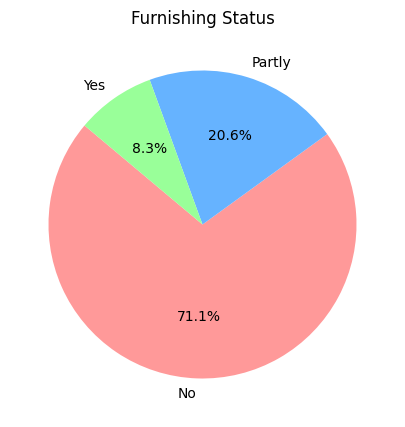

In [32]:
furnishing_counts = df['furnishing'].value_counts()
furnishing_labels = ['No', 'Partly', 'Yes']
plt.figure(figsize=(10, 5))
plt.pie(furnishing_counts, labels=furnishing_labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Furnishing Status')
plt.show()


<Axes: xlabel='price'>

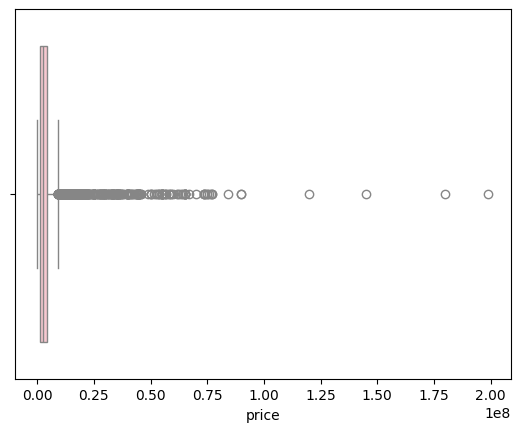

In [34]:
sns.boxplot(x=df['price'],color='pink')

<Axes: xlabel='price', ylabel='Count'>

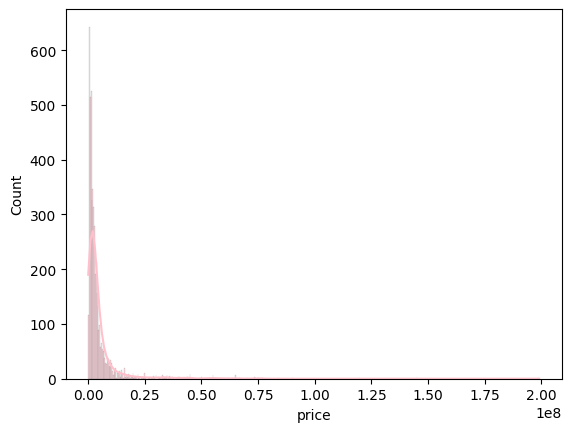

In [35]:
sns.histplot(df['price'], kde=True, color='pink')

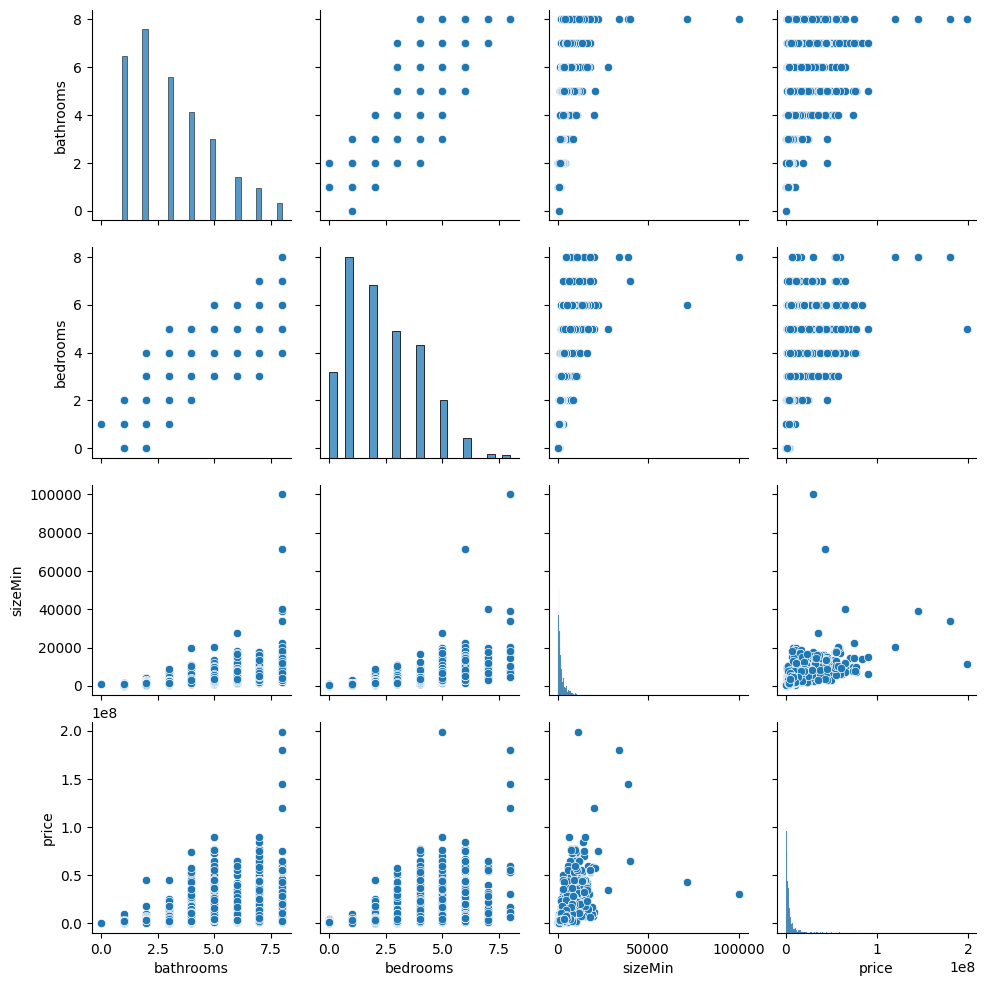

In [36]:
sns.pairplot(df[['bathrooms', 'bedrooms', 'sizeMin', 'price']])

<Axes: xlabel='furnishing', ylabel='count'>

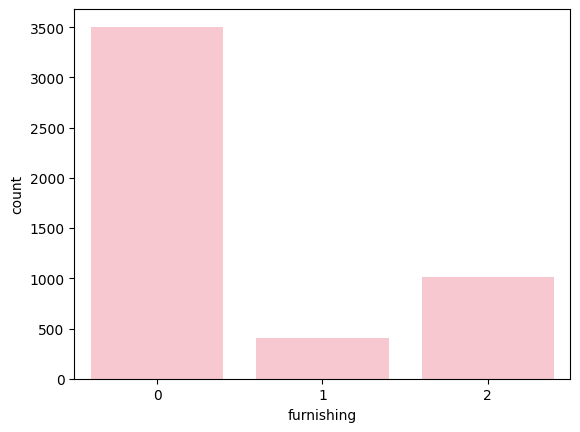

In [37]:
sns.countplot(x='furnishing', data=df, color='pink')

<Axes: >

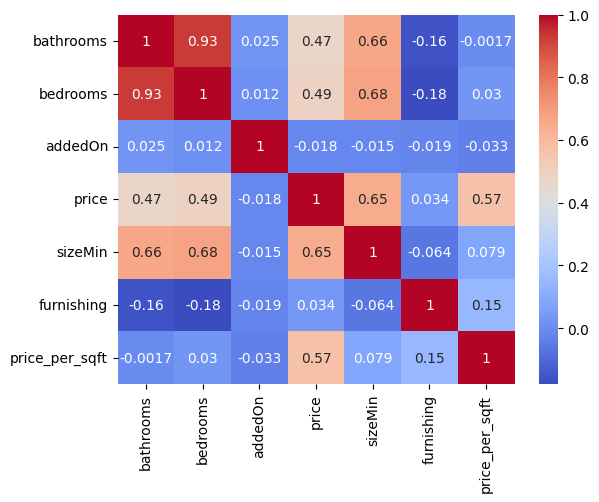

In [38]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')

<Axes: xlabel='bedrooms', ylabel='price'>

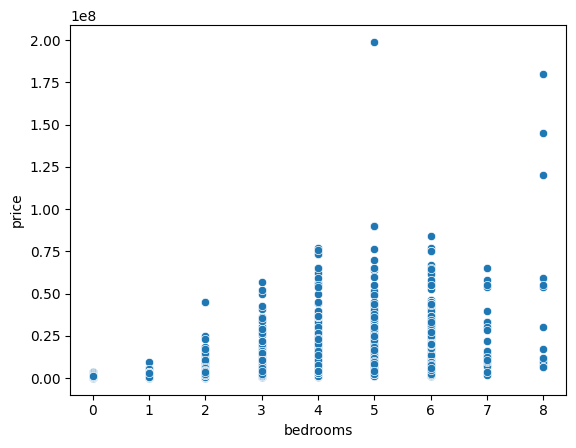

In [39]:
sns.scatterplot(x='bedrooms', y='price', data=df)

<Axes: xlabel='bathrooms', ylabel='price'>

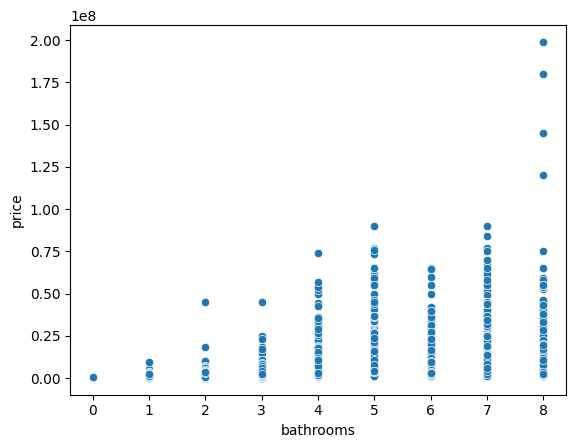

In [40]:
sns.scatterplot(x='bathrooms', y='price', data=df)


<Axes: xlabel='sizeMin', ylabel='price'>

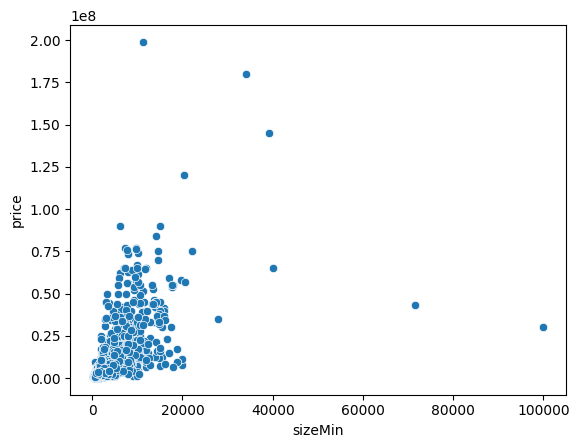

In [41]:
sns.scatterplot(x='sizeMin', y='price', data=df)

### Predictive Modeling


In [42]:
df.describe()

,bathrooms,bedrooms,addedOn,price,sizeMin,furnishing,price_per_sqft
count,4930.000000,4930.000000,4930.000000,4.930000e+03,4930.000000,4930.000000,4930.000000
mean,3.122312,2.340771,1129.504057,4.937866e+06,2362.908114,0.494929,1944.090872
std,1.827921,1.618737,53.115744,9.720128e+06,3240.017460,0.813556,1342.656037
min,0.000000,0.000000,0.000000,1.000000e+05,82.000000,0.000000,60.975610
25%,2.000000,1.000000,1119.000000,1.200000e+06,796.000000,0.000000,1152.601518
50%,3.000000,2.000000,1146.000000,2.350000e+06,1383.000000,0.000000,1575.028970
75%,4.000000,4.000000,1160.000000,4.400000e+06,2690.000000,1.000000,2364.747397
max,8.000000,8.000000,1174.000000,1.990000e+08,100000.000000,2.000000,17774.205073


In [43]:
x = df.drop(columns=['price','title', 'displayAddress','description'], axis=1)
y = df['price']

In [44]:
x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=101)

In [45]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### **Model Building**
**Linear Regression:**
A basic regression technique that models the relationship between dependent and independent variables as a straight line. It assumes linearity and is easy to interpret.

**Random Forest Regressor:**
An ensemble learning method that uses multiple decision trees to predict the target variable. It improves accuracy by averaging predictions and reducing overfitting.

**Support Vector Regressor (SVR):**
A regression version of SVM that finds the best-fit hyperplane within a margin of tolerance. It's effective for non-linear relationships but may require careful tuning of hyperparameters.

**Decision Tree Regressor:**
A tree-structured model that splits data into subsets based on feature values to predict outcomes. It is interpretable but prone to overfitting on small datasets.

**Lasso Regression:**
A linear regression model with L1 regularization, which penalizes large coefficients to improve generalization and perform feature selection by reducing some coefficients to zero.

**Ridge Regression:**
Similar to Lasso, but uses L2 regularization to shrink coefficients, helping to handle multicollinearity and avoid overfitting.

**XGBoost Regressor:**
A gradient boosting framework that builds strong predictive models by sequentially optimizing weak learners. It is highly efficient and powerful for structured data.

**K-Nearest Neighbors Regressor (KNN):**
A simple non-parametric method that predicts a value based on the average of its nearest neighbors. It works well for small datasets but can be computationally expensive for large ones.

In [46]:
models = {
'Linear Regression': LinearRegression(),
'Random Forest': RandomForestRegressor(n_estimators=100),
'SVR': SVR(),
'Decision Tree': DecisionTreeRegressor(),
'Lasso': Lasso(),
'Ridge': Ridge(),
'XGBoost': xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,learning_rate=0.1,max_depth=6, random_state=42),
'KNN': KNeighborsRegressor()
}

In [47]:
results=[]
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae= mean_absolute_error(y_test,y_pred)
    mse= mean_squared_error(y_test,y_pred)
    rmse= root_mean_squared_error(y_test,y_pred)
    r_sqaure = r2_score(y_test,y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    results.append([name, mae, mse, rmse,r_sqaure,mape])
    model_results = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE','R-Squared','MAPE'])
    model_results = model_results.sort_values('MAE', ascending=False).reset_index(drop=True)

### Metric Evaluation
**Mean Absolute Error (MAE):**
Measures the average magnitude of errors between predicted and actual values, without considering their direction. It gives a straightforward indication of prediction accuracy.

**Mean Squared Error (MSE):**
Calculates the average of the squared differences between predicted and actual values. It penalizes larger errors more heavily than smaller ones, making it sensitive to outliers.

**Root Mean Squared Error (RMSE):**
The square root of MSE, providing error magnitude in the same units as the target variable. It’s useful for understanding how much predictions deviate from actual values on average.

**R-Squared (R²):**
Indicates the proportion of variance in the target variable explained by the model. A value closer to 1 means the model fits the data well.

**Mean Absolute Percentage Error (MAPE):**
Measures the average percentage error between predicted and actual values. It’s useful for understanding model performance relative to the scale of the target variable.

In [48]:
model_results

,Model,MAE,MSE,RMSE,R-Squared,MAPE
0,SVR,3.892130e+06,1.138786e+14,1.067139e+07,-0.071378,0.995224
1,Linear Regression,2.769383e+06,3.314650e+13,5.757300e+06,0.688155,1.561349
2,Lasso,2.769382e+06,3.314650e+13,5.757300e+06,0.688155,1.561348
3,Ridge,2.769073e+06,3.314912e+13,5.757527e+06,0.688131,1.561062
4,KNN,9.988577e+05,1.451539e+13,3.809907e+06,0.863438,0.197062
5,XGBoost,4.743603e+05,1.336071e+13,3.655230e+06,0.874301,0.065753
6,Decision Tree,4.281418e+05,3.415702e+12,1.848162e+06,0.967865,0.058378
7,Random Forest,2.820128e+05,5.676691e+12,2.382581e+06,0.946593,0.034298


**SVR:** A massive MAPE of 99.52%, indicating that the model's predictions are off by nearly 100%, showing poor performance.

**Linear Regression, Lasso, and Ridge:** These models perform similarly with a 156.13% MAPE, suggesting they are making significant errors in predictions, as they are off by more than 150% on average.

**KNN:** With a 19.71% MAPE, KNN performs much better, showing a reasonable level of accuracy in predictions.

**XGBoost:** A standout with an impressive 6.58% MAPE, this model is significantly more accurate, making it one of the top performers.

**Decision Tree:** At 5.84% MAPE, Decision Tree performs just slightly worse than XGBoost, but still offers excellent predictions.

**Random Forest:** The best performer with the lowest 3.43% MAPE, showing very accurate predictions and outshining all other models.

### Comparison of Model Performance Across Metrics

In [49]:
metrics_long = model_results.melt(
    id_vars=['Model'],
    value_vars=['MAE', 'MSE', 'RMSE', 'R-Squared', 'MAPE'],
    var_name='Metric',
    value_name='Value'
)

In [50]:
sns.set_palette("husl")

C:\Users\DELL\AppData\Local\Temp\ipykernel_980\332473736.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")


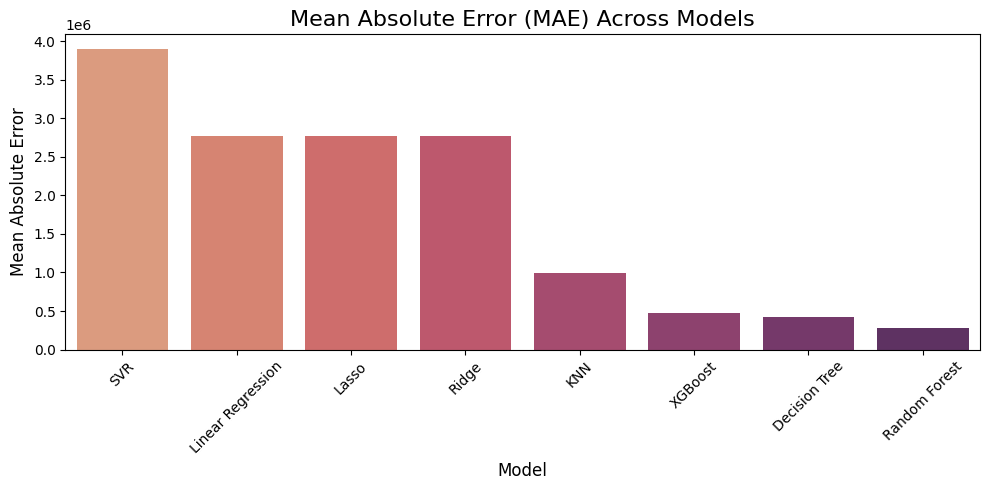

C:\Users\DELL\AppData\Local\Temp\ipykernel_980\332473736.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")


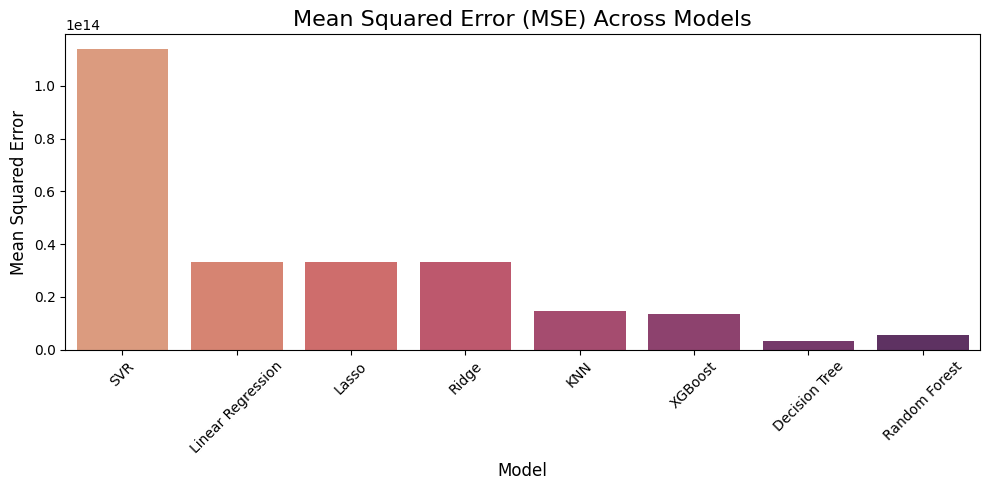

C:\Users\DELL\AppData\Local\Temp\ipykernel_980\332473736.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")


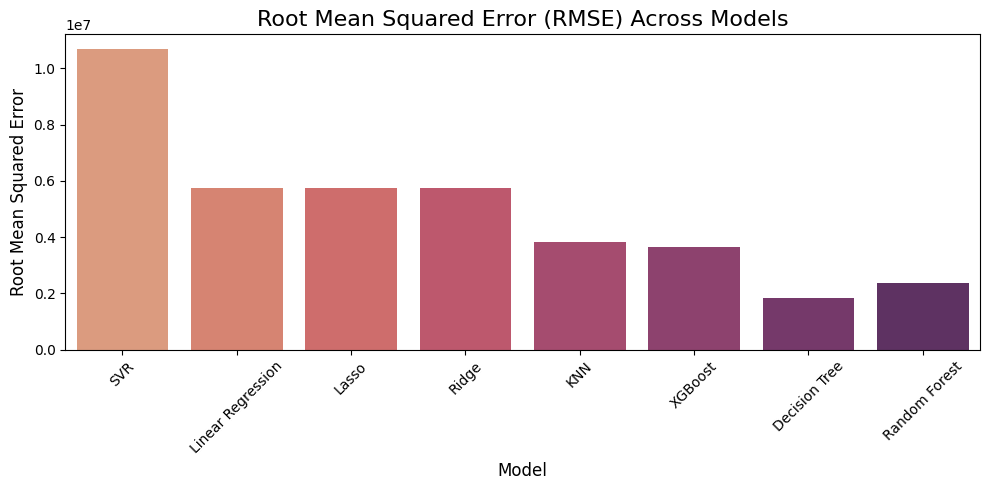

C:\Users\DELL\AppData\Local\Temp\ipykernel_980\332473736.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")


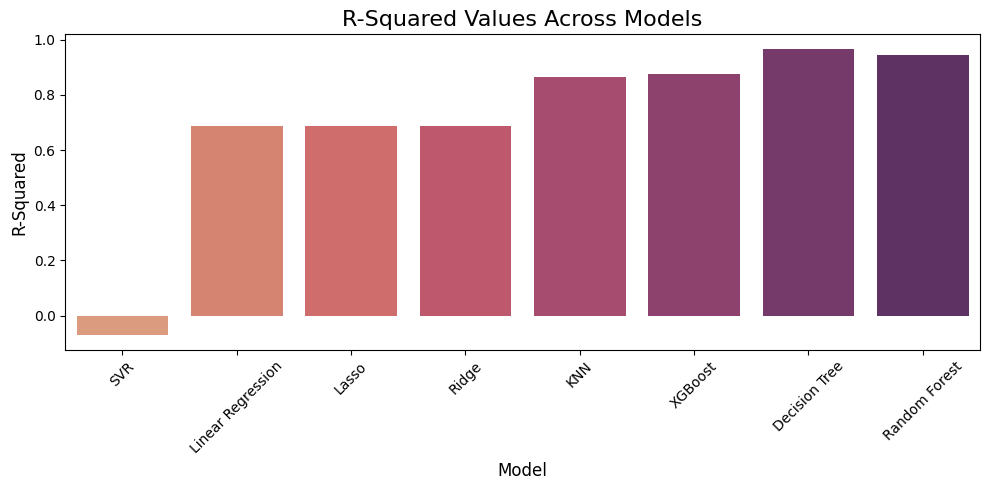

C:\Users\DELL\AppData\Local\Temp\ipykernel_980\332473736.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")


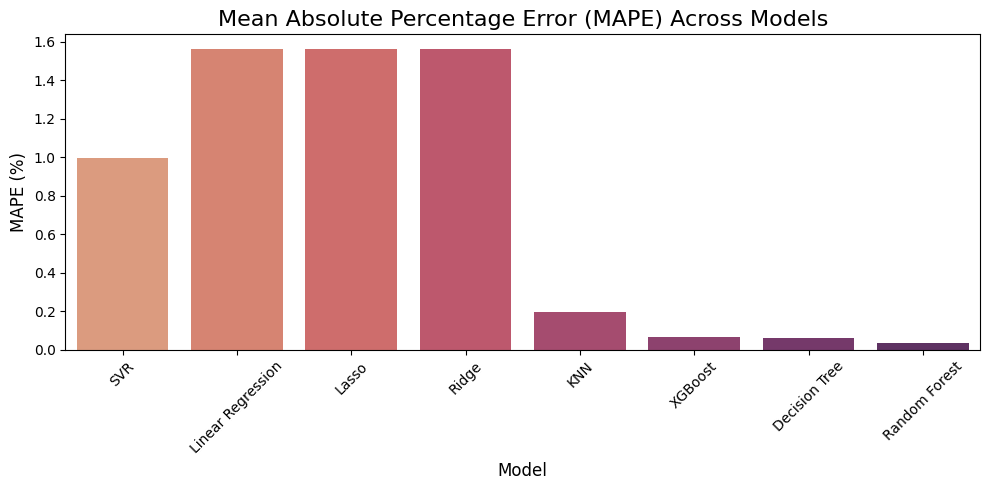

In [51]:
def plot_metric(metric_name, y_label, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=model_results, x='Model', y=metric_name, palette="flare")
    plt.title(title, fontsize=16)
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_metric('MAE', 'Mean Absolute Error', "Mean Absolute Error (MAE) Across Models")

plot_metric('MSE', 'Mean Squared Error', "Mean Squared Error (MSE) Across Models")

plot_metric('RMSE', 'Root Mean Squared Error', "Root Mean Squared Error (RMSE) Across Models")

plot_metric('R-Squared', 'R-Squared', "R-Squared Values Across Models")

model_results['MAPE_float'] = model_results['MAPE']
plot_metric('MAPE_float', 'MAPE (%)', "Mean Absolute Percentage Error (MAPE) Across Models")


### **Why Did Linear Regression Perform Poorly?**
Linear regression underperformed because it assumes a linear relationship between the features and the target variable, which is often not the case for complex datasets like house prices. Factors such as non-linear patterns, the presence of outliers, multicollinearity among features, and insufficient feature transformations hindered its effectiveness. Additionally, irrelevant or unprocessed features (e.g., text-heavy columns) likely introduced noise, further degrading the model’s performance. Advanced models like Random Forest or XGBoost are better suited for capturing the non-linear and intricate relationships in such datasets.

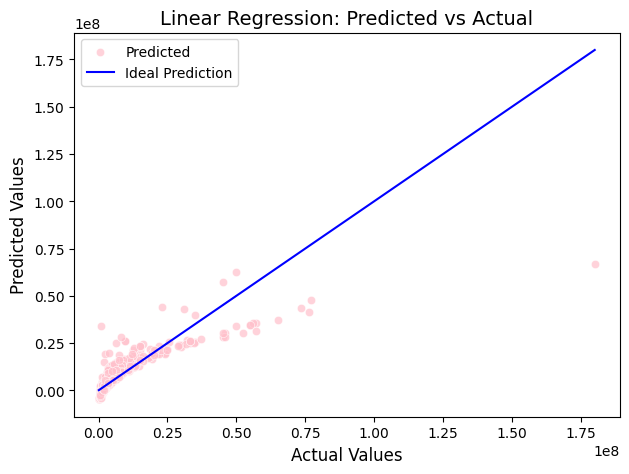

In [52]:
linear_model = LinearRegression()

linear_model.fit(x_train, y_train)

y_pred_linear = linear_model.predict(x_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_linear, alpha=0.7, color="pink", label="Predicted")
sns.lineplot(x=y_test, y=y_test, color="blue", label="Ideal Prediction")
plt.title("Linear Regression: Predicted vs Actual", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()


plt.tight_layout()
plt.show()


### **Why Did SVR Perform Poorly?**
SVR (Support Vector Regressor) may have underperformed because it is sensitive to the choice of hyperparameters such as the kernel type, regularization parameter, and epsilon. While SVR is effective for smaller datasets, it can struggle with large datasets due to its computational complexity. Additionally, despite preprocessing and feature engineering, the inherent non-linear patterns in house price prediction might not have been fully captured by the chosen SVR configuration, limiting its accuracy. Hyperparameter tuning or exploring alternative models might yield better results.

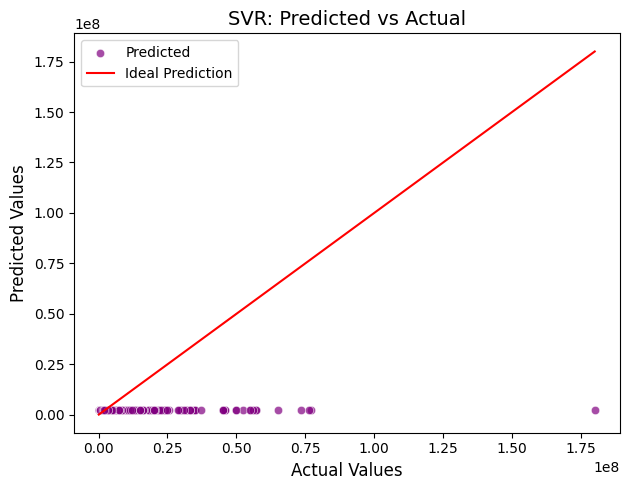

In [53]:
svr_model = SVR()

svr_model.fit(x_train, y_train)

y_pred_svr = svr_model.predict(x_test)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7, color="purple", label="Predicted")
sns.lineplot(x=y_test, y=y_test, color="red", label="Ideal Prediction")
plt.title("SVR: Predicted vs Actual", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


## **Results**
In this project, various machine learning models were evaluated for predicting house prices, with the MAPE (Mean Absolute Percentage Error) used as the key metric to assess accuracy. The SVR (Support Vector Regressor) model showed the poorest performance, with a staggering 99.52% MAPE, indicating nearly 100% error in predictions. Linear Regression, Lasso, and Ridge models also performed poorly, each exhibiting a 156.13% MAPE, suggesting large errors in their predictions. On the other hand, KNN (K-Nearest Neighbors) showed a much better result with a 19.71% MAPE, providing a reasonable level of accuracy. The models that stood out as top performers were XGBoost and Decision Tree, with 6.58% and 5.84% MAPE, respectively, indicating strong predictive power. However, the best model was Random Forest, achieving the lowest MAPE of 3.43%, making it the most accurate for house price prediction in this project. Therefore, Random Forest is the optimal model, with XGBoost and Decision Tree also providing excellent predictions, while the others struggled with large prediction errors.